# Ring modulator PN Junction

In [1]:
# Import the necassry packages
import gplugins.modes as gm
import gplugins.gmeep as gmeep
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import meep as mp
import gplugins.tidy3d as gt
import gdsfactory as gf
# from ubcpdk import PDK, cells
from functools import partial
# PDK.activate()
import sax
from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
from simphony.libraries import siepic
from gplugins.devsim import get_simulation_xsection
from gplugins.devsim.get_simulation_xsection import k_to_alpha, clear_devsim_cache
import pyvista as pv
import os

Using MPI version 4.1, 1 processes
2025-12-10 01:53:50.527 | INFO     | gplugins.gmeep:<module>:39 - Meep '1.31.0' installed at ['/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/meep']
Searching DEVSIM_MATH_LIBS="libopenblas.so:liblapack.so:libblas.so"
Loading "libopenblas.so": ALL BLAS/LAPACK LOADED
Skipping liblapack.so
Skipping libblas.so
loading UMFPACK 5.1 as direct solver
2025-12-10 01:53:53.389 | INFO     | gplugins.devsim:<module>:16 - DEVSIM '2.10.0' installed at ['/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/devsim']


# Design of PN junction

Loading a straing pn junciton component from gdsfactory 

The aim is to do full TCAD simulation to get the Vpi

## Step 1: Import PN junction straight waveguide form GDSFactory

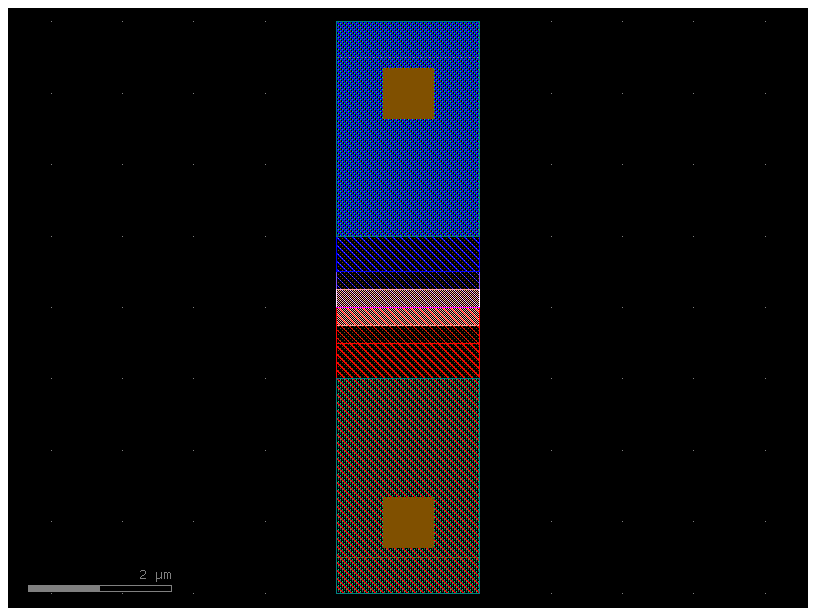

In [2]:
import gdsfactory as gf
from gdsfactory.generic_tech import LAYER, LAYER_STACK
from gdsfactory.technology import LayerLevel, LayerStack

# We choose a representative subdomain of the component
waveguide = gf.Component()
waveguide.add_ref(
    gf.functions.trim(
        component=gf.components.straight_pn(length=10, taper=None).copy(),
        domain=[[3, -4], [3, 4], [5, 4], [5, -4]],
    )
)

waveguide.plot()

scene = waveguide.to_3d()
scene.show()

Run a TCAD simualtion to calculate the carrier desnity of electron (dN) and holes (dP)

In [3]:
active_layer_stack = gf.pdk.get_active_pdk().layer_stack
active_layer_stack.layers


{'substrate': LayerLevel(name=None, layer=WAFER, derived_layer=None, thickness=10.0, thickness_tolerance=None, width_tolerance=None, zmin=-13.0, zmin_tolerance=None, sidewall_angle=0.0, sidewall_angle_tolerance=None, width_to_z=0.0, z_to_bias=None, bias=None, mesh_order=101, material='si', info={}),
 'box': LayerLevel(name=None, layer=WAFER, derived_layer=None, thickness=3.0, thickness_tolerance=None, width_tolerance=None, zmin=-3.0, zmin_tolerance=None, sidewall_angle=0.0, sidewall_angle_tolerance=None, width_to_z=0.0, z_to_bias=None, bias=None, mesh_order=9, material='sio2', info={}),
 'core': LayerLevel(name=None, layer=((WG - DEEP_ETCH) - SHALLOW_ETCH), derived_layer=WG, thickness=0.22, thickness_tolerance=None, width_tolerance=None, zmin=0.0, zmin_tolerance=None, sidewall_angle=10.0, sidewall_angle_tolerance=None, width_to_z=0.5, z_to_bias=None, bias=None, mesh_order=2, material='si', info={}),
 'shallow_etch': LayerLevel(name=None, layer=(SHALLOW_ETCH & WG), derived_layer=SLAB150

Simple step doping. See below for complex doping profile

In [4]:
%%capture  
um = 1e-6
c = get_simulation_xsection.PINWaveguide(
    core_width=0.500 * um,
    core_thickness=0.220 * um,
    slab_thickness=0.090 * um,
)
# Initialize mesh and solver
clear_devsim_cache()
c.ddsolver()
c.save_device('straight_PN.dat')


2025-12-09 13:17:00.350 ( 114.370s) [    766F7929F740]vtkXOpenGLRenderWindow.:1458  WARN| bad X server connection. DISPLAY=
/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


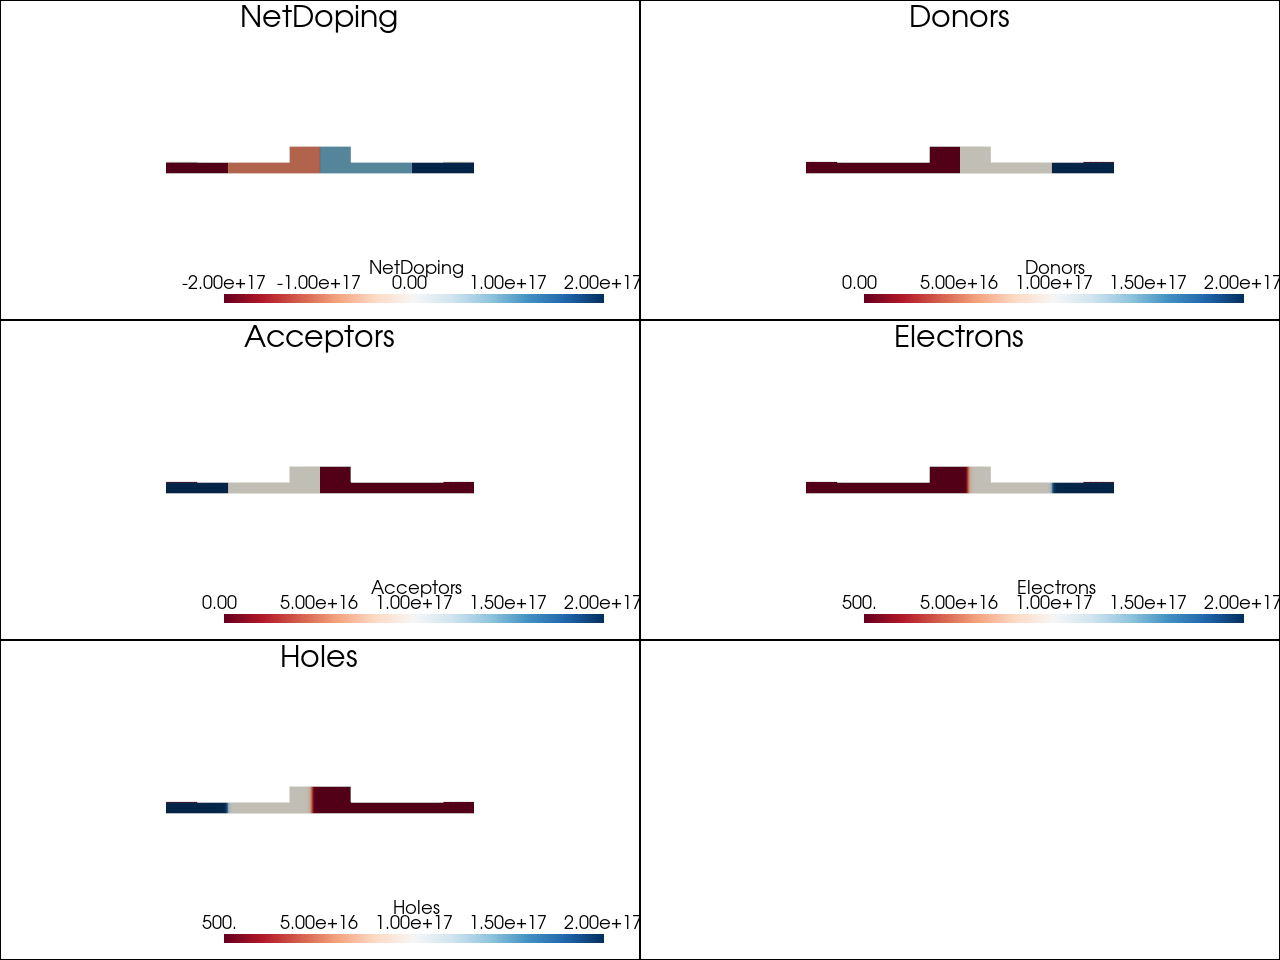

In [5]:
mesh = pv.read('straight_PN.dat')
fields = [
    "NetDoping","Donors","Acceptors",
    "Electrons","Holes"]

p = pv.Plotter(shape=(3,2), notebook='static', window_size=(320*4, 240*4))
# c.plot(scalars="NetDoping", jupyter_backend="static")

idx = 0
for r in range(3):
    for ccol in range(2):
        p.subplot(r, ccol)

        if idx >= len(fields):
            p.add_text("")  # empty cell
            continue

        fname = fields[idx]
        idx += 1

        # if fname not in mesh.array_names:
        #     p.add_text(f"Missing {fname}")
        #     continue

        p.add_mesh(mesh, scalars=fname, cmap="RdBu")
        p.add_text(fname, position="upper_edge", font_size=12)
        _ = p.camera_position = "xy"
        p.add_scalar_bar(title=fname)

p.link_views()
p.show()

Applying voltage and finding the solution

Making waveguide from the devsim device with perturebd index and calculaitng the effective index. Using tidy3d for the mode calcaultions

In [ ]:
%%capture
voltages = [0, -0.5, -1, -1.5, -2, -2.5, -3, -3.5, -4, -5, -6, -7, -8, -9, -10]
ramp_rate = -0.1

n_dist = {}
neffs = {}
clear_devsim_cache()
um = 1e-6

dev = get_simulation_xsection.PINWaveguide(
    core_width=0.500 * um,
    core_thickness=0.220 * um,
    slab_thickness=0.090 * um,
)
dev.ddsolver()     # fresh, clean equilibrium state
for ind, voltage in enumerate(voltages):
    Vinit = 0 if ind == 0 else voltages[ind - 1]
    dev.ramp_voltage(Vfinal=voltage, Vstep=ramp_rate, Vinit=Vinit)
    waveguide = dev.make_waveguide(wavelength=1.55,grid_resolution=20)
    n_dist[voltage] = waveguide.index.values
    neffs[voltage] = waveguide.n_eff[0]

np.save("neffs_TCAD.npz", neffs)

np.complex128(2.5932203425309455+3.8757826065200905e-05j)

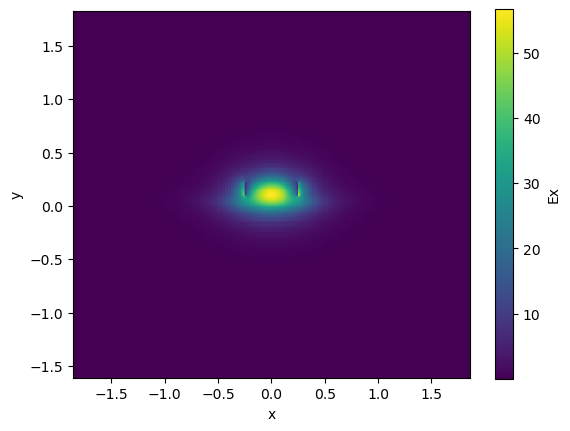

In [7]:
import gplugins.tidy3d as td
wg_td = td.modes.Waveguide(wavelength=1.55,
                core_width=0.5,
                core_thickness=0.22,
                slab_thickness=0.090,
                grid_resolution=50,
                core_material='si',
                clad_material='sio2',
                cache_path=None,
                overwrite=True)
wg_td.plot_field('Ex')
wg_td.n_eff[0]

In [3]:
neffs = {0: np.complex128(2.579233149832461+4.2558454254802517e-05j),
 -0.5: np.complex128(2.579248605051533+4.20043472854569e-05j),
 -1: np.complex128(2.5792605310824923+4.1578101252069765e-05j),
 -1.5: np.complex128(2.5792684479189205+4.1298845722944675e-05j),
 -2: np.complex128(2.5792768911186554+4.100265496131908e-05j),
 -2.5: np.complex128(2.579284107736812+4.0752849952389265e-05j),
 -3: np.complex128(2.5719153080505834+4.2195904369172816e-05j),
 -3.5: np.complex128(2.5792960309736594+4.033633789155556e-05j),
 -4: np.complex128(2.57930195707953+4.012628342291738e-05j),
 -5: np.complex128(2.5793103370214245+3.9827958190374006e-05j),
 -6: np.complex128(2.5793178726112416+3.956270654250005e-05j),
 -7: np.complex128(2.579323275257858+3.935982457145146e-05j),
 -8: np.complex128(2.5719524331528962+4.084224984011639e-05j),
 -9: np.complex128(2.5793333855608185+3.901735265199731e-05j),
 -10: np.complex128(2.5793378293861204+3.888440364347489e-05j)}

neffs

{0: np.complex128(2.579233149832461+4.2558454254802517e-05j),
 -0.5: np.complex128(2.579248605051533+4.20043472854569e-05j),
 -1: np.complex128(2.5792605310824923+4.1578101252069765e-05j),
 -1.5: np.complex128(2.5792684479189205+4.1298845722944675e-05j),
 -2: np.complex128(2.5792768911186554+4.100265496131908e-05j),
 -2.5: np.complex128(2.579284107736812+4.0752849952389265e-05j),
 -3: np.complex128(2.5719153080505834+4.2195904369172816e-05j),
 -3.5: np.complex128(2.5792960309736594+4.033633789155556e-05j),
 -4: np.complex128(2.57930195707953+4.012628342291738e-05j),
 -5: np.complex128(2.5793103370214245+3.9827958190374006e-05j),
 -6: np.complex128(2.5793178726112416+3.956270654250005e-05j),
 -7: np.complex128(2.579323275257858+3.935982457145146e-05j),
 -8: np.complex128(2.5719524331528962+4.084224984011639e-05j),
 -9: np.complex128(2.5793333855608185+3.901735265199731e-05j),
 -10: np.complex128(2.5793378293861204+3.888440364347489e-05j)}

Text(0.5, 1.0, 'Imaginary part of refractive index (k)')

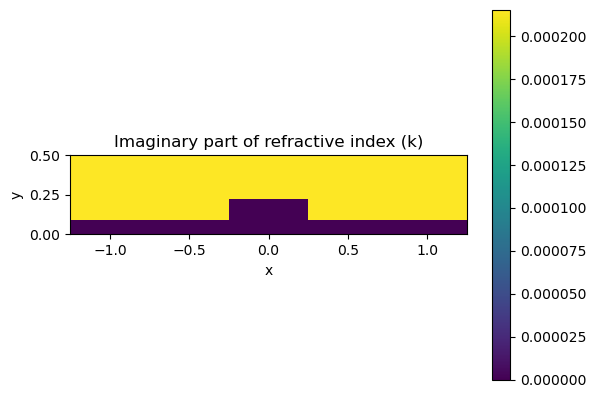

In [20]:
c_undoped = c.make_waveguide(wavelength=1.55, perturb=False, precision="double", grid_resolution=20)
# c_undoped.compute_modes()
n_undoped = c_undoped.index.values
ax2 =  c_undoped.index.imag.plot()
ax2.axes.set_aspect("equal")
ax2.axes.set_ylim([0, 0.5])
plt.title("Imaginary part of refractive index (k)")

/tmp/ipykernel_2576937/1825642260.py:5: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.abs(np.imag(n_dist[voltage]- n_undoped))),


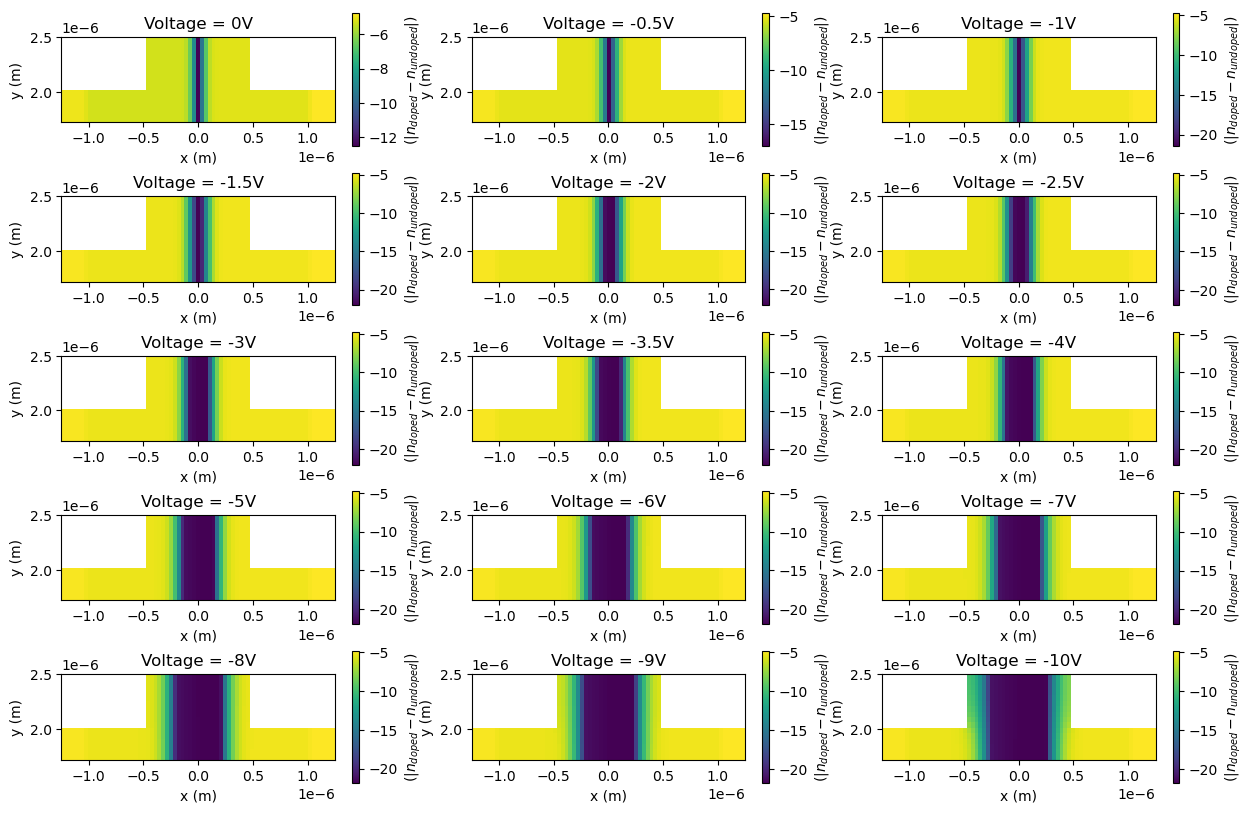

In [26]:
plt.figure(figsize=(15,10))
for ind, voltage in enumerate(voltages):
    plt.subplot(5,3,ind+1)
    plt.imshow(
        np.log10(np.abs(np.imag(n_dist[voltage]- n_undoped))),
        origin="lower",
        extent=[
            -c.xmargin - c.ppp_offset - c.core_width / 2,
            c.xmargin + c.npp_offset + c.core_width / 2,
            0,
            c.clad_thickness + c.box_thickness + c.core_thickness,
        ],
    )
    plt.colorbar(label="$(|n_{doped} - n_{undoped}|)$")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.ylim(1.72e-6, 2.5e-6)
    plt.title(f"Voltage = {voltage}V")

Calacute the Vpi then have to build the compact model for the same. Finally use this in the ring resonator model

Phase change can be claculated form dn. So using this Vpi is calcaulted

Not too good - But okay for a proof of concept design

# Calcaultion of $\Delta\phi$, $V_\pi$, and losses

Reference neff at V=0: 2.579233 + 4.255845e-05j
Polynomial coefficients (real): [-1.29579665e-08 -3.65556855e-07 -4.18175593e-06 -2.85415793e-05
  2.57923431e+00]
Polynomial coefficients (imag): [5.58598343e-10 1.47369348e-08 1.57973530e-07 1.02659610e-06
 4.25162637e-05]


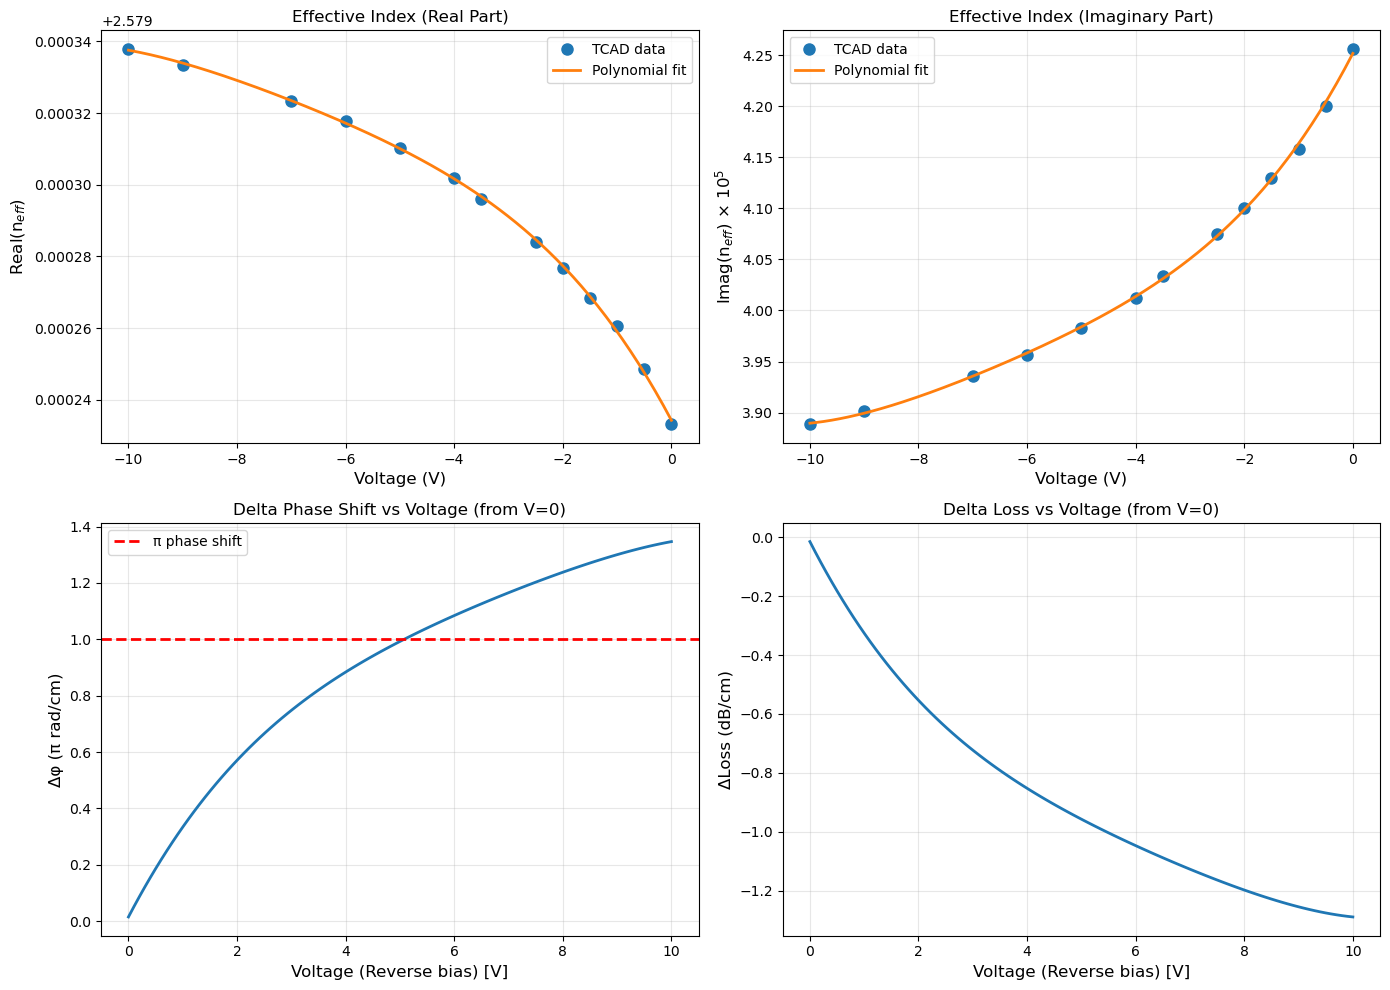


PN Junction Phase Shifter Characteristics (CORRECTED):
V-π·L product: 5.08 V·cm
For L=1mm (0.1cm): V-π ≈ 50.75 V
For L=500μm (0.05cm): V-π ≈ 101.50 V
For L=100μm (0.01cm): V-π ≈ 507.51 V



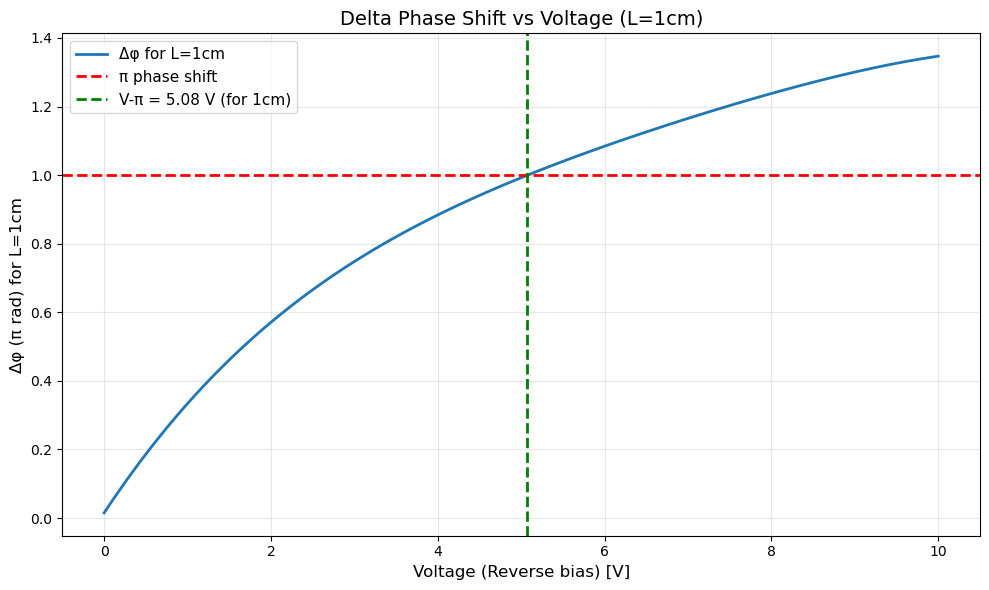

In [2]:
from scipy.interpolate import interp1d

# ============================================
# Step 1: Load TCAD data and fit polynomials
# ============================================
neffs = np.load("neffs_TCAD.npy", allow_pickle=True)
neffs_data = neffs[()]
voltages_data = np.array(sorted(neffs_data.keys()))
neff_values = np.array([neffs_data[v] for v in voltages_data])
neff_real_data = np.real(neff_values)
neff_imag_data = np.imag(neff_values)

# Create interpolation functions (cubic spline for smoothness)
neff_real_interp = interp1d(voltages_data, neff_real_data, kind='cubic',
                            fill_value='extrapolate', bounds_error=False)
neff_imag_interp = interp1d(voltages_data, neff_imag_data, kind='cubic',
                            fill_value='extrapolate', bounds_error=False)

# Fit polynomials for JAX compatibility
poly_real_coeffs = np.polyfit(voltages_data, neff_real_data, deg=4)
poly_imag_coeffs = np.polyfit(voltages_data, neff_imag_data, deg=4)

# Convert to JAX arrays
poly_real_coeffs_jax = jnp.array(poly_real_coeffs)
poly_imag_coeffs_jax = jnp.array(poly_imag_coeffs)

# Reference values at V=0
neff0_real = float(neff_real_interp(0.0))
neff0_imag = float(neff_imag_interp(0.0))

print(f"Reference neff at V=0: {neff0_real:.6f} + {neff0_imag:.6e}j")
print(f"Polynomial coefficients (real): {poly_real_coeffs}")
print(f"Polynomial coefficients (imag): {poly_imag_coeffs}")

# ============================================
# Step 3: Validation and Visualization
# ============================================

def validate_pn_model():
    """Validate the PN junction model against TCAD data"""
    
    V_test = np.linspace(0, -10, 100)
    
    # Calculate delta phase and loss changes
    delta_phases = []
    delta_losses = []
    
    for v in V_test:
        neff_real_V = np.polyval(poly_real_coeffs, v)
        neff_imag_V = np.polyval(poly_imag_coeffs, v)
        delta_neff_real = neff_real_V - neff0_real
        delta_neff_imag = neff_imag_V - neff0_imag
        
        # Delta phase for 100 μm
        delta_phi = 2 * np.pi * delta_neff_real * 100.0 / 1.55
        delta_phases.append(delta_phi)
        
        # Delta loss for 100 μm (CORRECTED)
        wl_cm = 1.55 * 1e-4
        length_cm = 100.0 * 1e-4
        delta_loss_per_cm = (4 * np.pi * delta_neff_imag * 4.343) / wl_cm
        delta_loss = delta_loss_per_cm * length_cm
        delta_losses.append(delta_loss)
    
    delta_phases = np.array(delta_phases)
    delta_losses = np.array(delta_losses)
    
    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Real(neff)
    axes[0, 0].plot(voltages_data, neff_real_data, 'o', markersize=8, label='TCAD data')
    V_fine = np.linspace(0, -10, 200)
    neff_real_fit = np.polyval(poly_real_coeffs, V_fine)
    axes[0, 0].plot(V_fine, neff_real_fit, '-', linewidth=2, label='Polynomial fit')
    axes[0, 0].set_xlabel('Voltage (V)', fontsize=12)
    axes[0, 0].set_ylabel('Real(n$_{eff}$)', fontsize=12)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_title('Effective Index (Real Part)')
    
    # Plot 2: Imag(neff)
    axes[0, 1].plot(voltages_data, neff_imag_data * 1e5, 'o', markersize=8, label='TCAD data')
    neff_imag_fit = np.polyval(poly_imag_coeffs, V_fine)
    axes[0, 1].plot(V_fine, neff_imag_fit * 1e5, '-', linewidth=2, label='Polynomial fit')
    axes[0, 1].set_xlabel('Voltage (V)', fontsize=12)
    axes[0, 1].set_ylabel('Imag(n$_{eff}$) × 10$^5$', fontsize=12)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_title('Effective Index (Imaginary Part)')
    
    # Plot 3: DELTA Phase (CORRECTED)
    delta_phases_per_cm = delta_phases / (100e-4)
    axes[1, 0].plot(-V_test, delta_phases_per_cm / np.pi, '-', linewidth=2)
    axes[1, 0].axhline(y=1, color='r', linestyle='--', linewidth=2, label='π phase shift')
    axes[1, 0].set_xlabel('Voltage (Reverse bias) [V]', fontsize=12)
    axes[1, 0].set_ylabel('Δφ (π rad/cm)', fontsize=12)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_title('Delta Phase Shift vs Voltage (from V=0)')
    
    # Plot 4: DELTA Loss (CORRECTED)
    delta_losses_per_cm = delta_losses / (100e-4)
    axes[1, 1].plot(-V_test, delta_losses_per_cm, '-', linewidth=2)
    axes[1, 1].set_xlabel('Voltage (Reverse bias) [V]', fontsize=12)
    axes[1, 1].set_ylabel('ΔLoss (dB/cm)', fontsize=12)
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_title('Delta Loss vs Voltage (from V=0)')
    
    plt.tight_layout()
    plt.show()
    
    # =================================================================
    # CORRECTED V-pi CALCULATION using DELTA phase
    # =================================================================
    def get_delta_phase_for_vpi(voltage, length=1e4):
        """Calculate DELTA phase for given voltage and length"""
        neff_real_V = np.polyval(poly_real_coeffs, voltage)
        delta_neff_real = neff_real_V - neff0_real
        return 2 * np.pi * delta_neff_real * length / 1.55
    
    V_test_fine = np.linspace(0, -10, 1000)
    delta_phases_1cm = np.array([get_delta_phase_for_vpi(v) for v in V_test_fine])
    
    # Find voltage where DELTA phase = π
    idx_vpi = np.argmin(np.abs(delta_phases_1cm - np.pi))
    V_pi_1cm = np.abs(V_test_fine[idx_vpi])
    
    print(f"\n{'='*60}")
    print(f"PN Junction Phase Shifter Characteristics (CORRECTED):")
    print(f"{'='*60}")
    print(f"V-π·L product: {V_pi_1cm:.2f} V·cm")
    print(f"For L=1mm (0.1cm): V-π ≈ {V_pi_1cm/0.1:.2f} V")
    print(f"For L=500μm (0.05cm): V-π ≈ {V_pi_1cm/0.05:.2f} V")
    print(f"For L=100μm (0.01cm): V-π ≈ {V_pi_1cm/0.01:.2f} V")
    print(f"{'='*60}\n")
    
    # Plot V-pi calculation
    fig2, ax = plt.subplots(figsize=(10, 6))
    ax.plot(-V_test_fine, delta_phases_1cm / np.pi, linewidth=2, label='Δφ for L=1cm')
    ax.axhline(y=1, color='r', linestyle='--', linewidth=2, label='π phase shift')
    ax.axvline(x=V_pi_1cm, color='g', linestyle='--', linewidth=2,
                label=f'V-π = {V_pi_1cm:.2f} V (for 1cm)')
    ax.set_xlabel('Voltage (Reverse bias) [V]', fontsize=12)
    ax.set_ylabel('Δφ (π rad) for L=1cm', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_title('Delta Phase Shift vs Voltage (L=1cm)', fontsize=14)
    plt.tight_layout()
    plt.show()

# Run validation
validate_pn_model()

# Building a compact model of the the pn-straight

In [3]:
def phase_shifter_pn_junction(
    wl: float = 1.55,
    voltage: float = 0.0,
    length: float = 10.0,
    neff0_real: float = neff0_real,
    neff0_imag: float = neff0_imag,
    poly_real: jnp.ndarray = poly_real_coeffs_jax,
    poly_imag: jnp.ndarray = poly_imag_coeffs_jax,
) -> sax.SDict:
    """
    PN junction phase shifter model with voltage-dependent neff.
    CORRECTED: Uses proper loss formula and delta phase calculation.
    
    Args:
        wl: wavelength in microns.
        voltage: applied voltage in Volts (negative for reverse bias).
        length: phase shifter length in microns.
        neff0_real: reference real part of neff at V=0.
        neff0_imag: reference imaginary part of neff at V=0.
        poly_real: polynomial coefficients for real(neff) vs voltage.
        poly_imag: polynomial coefficients for imag(neff) vs voltage.
    
    Returns:
        S-parameter dictionary compatible with SAX.
    """
    
    # Get neff at this voltage
    neff_real_V = jnp.polyval(poly_real, voltage)
    neff_imag_V = jnp.polyval(poly_imag, voltage)
    
    # Calculate CHANGE in neff from reference (V=0)
    delta_neff_real = neff_real_V - neff0_real
    delta_neff_imag = neff_imag_V - neff0_imag
    
    # =================================================================
    # PHASE: Static + Dynamic
    # =================================================================
    phase_static = 2 * jnp.pi * neff0_real * length / wl
    delta_phase = 2 * jnp.pi * delta_neff_real * length / wl
    phase_total = phase_static + delta_phase
    
    # =================================================================
    # LOSS (CORRECTED FORMULA): α [dB/cm] = (4π × k × 4.343) / λ[cm]
    # =================================================================
    wl_cm = wl * 1e-4  # Convert μm to cm
    length_cm = length * 1e-4  # Convert μm to cm
    
    # Static loss at V=0
    loss_static_per_cm = (4 * jnp.pi * neff0_imag * 4.343) / wl_cm
    
    # Dynamic loss change
    delta_loss_per_cm = (4 * jnp.pi * delta_neff_imag * 4.343) / wl_cm
    
    # Total loss
    loss_per_cm = loss_static_per_cm + delta_loss_per_cm
    loss_total_db = loss_per_cm * length_cm
    amplitude = jnp.asarray(10 ** (-loss_total_db / 20), dtype=complex)
    
    # Complex transmission
    transmission = amplitude * jnp.exp(1j * phase_total)
    
    return sax.reciprocal({
        ("o1", "o2"): transmission,
    })

Simple straight waveguide model

In [5]:
wavelengths = np.linspace(1.5, 1.6, 50)
lda_c = wavelengths[wavelengths.size // 2]
width = 0.45
pdk = gf.get_active_pdk()


layer_stack = pdk.get_layer_stack()
core = layer_stack.layers["core"]
clad = layer_stack.layers["clad"]
box = layer_stack.layers["box"]
slab = layer_stack.layers["slab90"]
layer_stack.layers.pop("substrate", None)

print(
    f"""Stack:
- {clad.material} clad with {clad.thickness}µm
- {core.material} clad with {core.thickness}µm
- {box.material} clad with {box.thickness}µm
# - {slab.material} slab with {slab.thickness}µm """
)

Stack:
- sio2 clad with 3.0µm
- si clad with 0.22µm
- sio2 clad with 3.0µm
# - si slab with 0.09µm 


2025-12-10 01:54:25.759 | INFO     | gplugins.tidy3d.modes:_data:266 - load data from /home/ramprakash/.gdsfactory/modes/Waveguide_041c32d6f4a389a6.npz.


/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/numpy/_core/getlimits.py:559: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/numpy/_core/getlimits.py:91: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


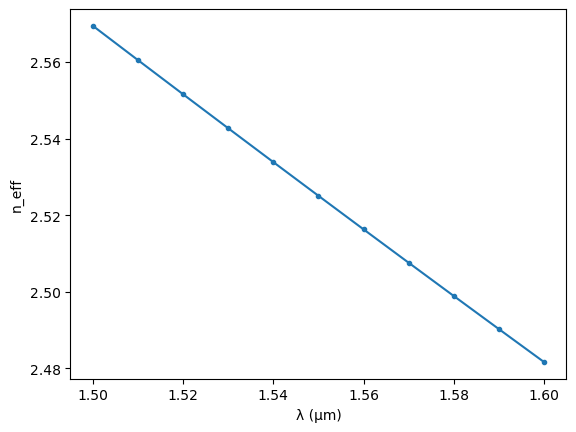

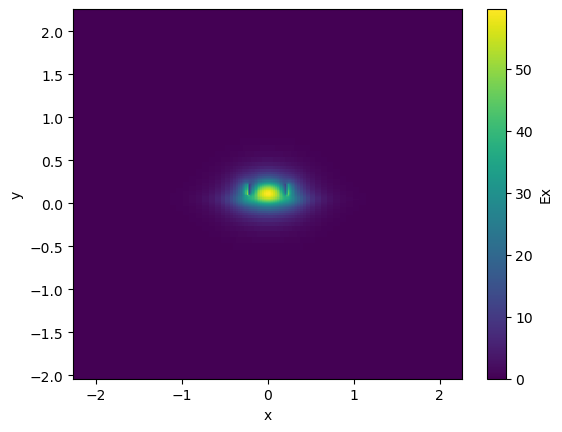

In [6]:
# calulating neff using tidy3d mode solver - free
straight_wavelengths = jnp.linspace(wavelengths[0], wavelengths[-1], 11)
straight_neffs = np.empty(straight_wavelengths.size, dtype=complex)
mode_solver_specs = dict(
    core_material=core.material,
    clad_material=clad.material,
    slab_thickness=slab.thickness,
    core_width=width,
    core_thickness=core.thickness,
    box_thickness=min(2.0, box.thickness),
    clad_thickness=min(2.0, clad.thickness),
    side_margin=2.0,
    num_modes=2,
    grid_resolution=20,
    precision="double",
)
waveguide_solver = gt.modes.Waveguide(
    wavelength=list(straight_wavelengths),
    **mode_solver_specs
)
straight_neffs = waveguide_solver.n_eff[:, 0]
plt.plot(straight_wavelengths, straight_neffs.real, ".-")
plt.xlabel("λ (µm)")
plt.ylabel("n_eff")
plt.show()
waveguide_solver.plot_field('Ex')

In [7]:
@jax.jit
def complex_interp(xs, x, y):
    ys_mag = jnp.interp(xs, x, jnp.abs(y))
    ys_phase = jnp.interp(xs, x, jnp.unwrap(jnp.angle(y)))
    return ys_mag * jnp.exp(1j * ys_phase)


@jax.jit
def straight_model(wl=np.linspace(1.45, 1.65, 50), length: float = 1.0):
    n_eff = complex_interp(wl, straight_wavelengths, straight_neffs.real)
    s21 = jnp.exp(2j * jnp.pi * n_eff * length / wl)
    zero = jnp.zeros_like(wl)
    return {
        ("o1", "o1"): zero,
        ("o1", "o2"): s21,
        ("o2", "o1"): s21,
        ("o2", "o2"): zero,
    }


straight_model(wl=1.55)

{('o1', 'o1'): Array(0., dtype=float64, weak_type=True),
 ('o1', 'o2'): Array(-0.68878147-0.72496902j, dtype=complex128),
 ('o2', 'o1'): Array(-0.68878147-0.72496902j, dtype=complex128),
 ('o2', 'o2'): Array(0., dtype=float64, weak_type=True)}

# Compact model for the coupler region

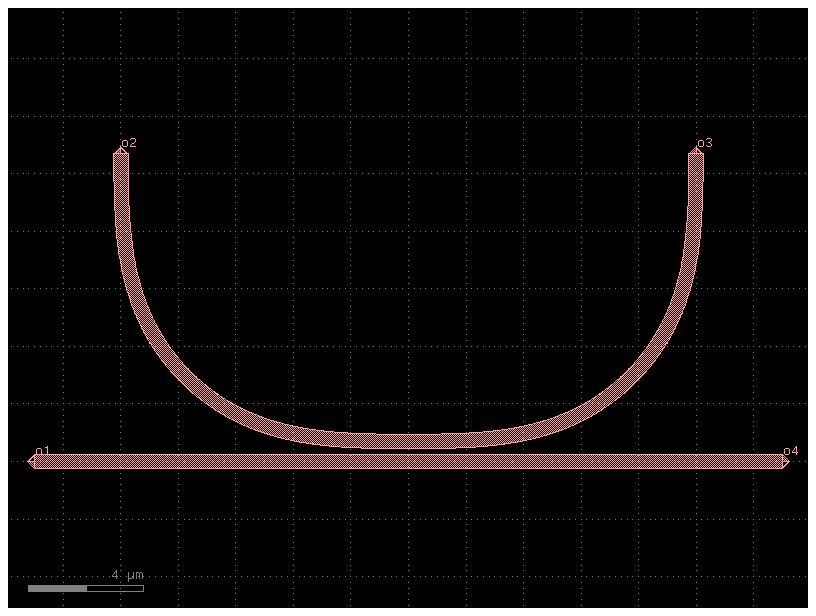

In [8]:
gap=0.2
length_x=0
coupler_ring_par = partial(
    gf.components.coupler_ring,
    gap=gap,
    length_x=length_x,
    cross_section='strip'
)
coupler_ring = coupler_ring_par(gap=gap, length_x=length_x)
coupler_ring.draw_ports()
coupler_ring.plot()

In [9]:
from pathlib import Path
wavelengths = np.linspace(1.5, 1.6, 50)
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.45)

resolution = 20
dpml = 1
pad = 1
s = gmeep.write_sparameters_meep_mpi(
        coupler_ring,
        cores=16,
        xmargin_left=1,
        xmargin_right=1,
        ymargin_top=1,
        ymargin_bot=1,
        port_source_names=['o1'],
        port_source_modes={'o1':[0]},
        port_modes=[0],
        filepath=Path(f'/home/ramprakash/Integrated_Tests/test_outputs/coupler_ring_gap_0.2.npz'),
        tpml=dpml,
        # extend_ports_length=0,  # Extend ports to create space for sources/monitors
        resolution=resolution,
        wavelength_start=wavelengths[0],
        wavelength_stop=wavelengths[-1],
        wavelength_points=len(wavelengths),
        port_source_offset=-0.5,
        port_monitor_offset=-0.1,
        distance_source_to_monitors=0.3,
        # port_symmetries=port_symmetries_coupler,
        layer_stack=layer_stack,
        # material_name_to_meep=dict(si=core_material),
        is_3d=False,
        overwrite=False,
        run=False
        )


2025-12-10 01:55:04.996 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/coupler_ring_gap_0.2.npz') already exists


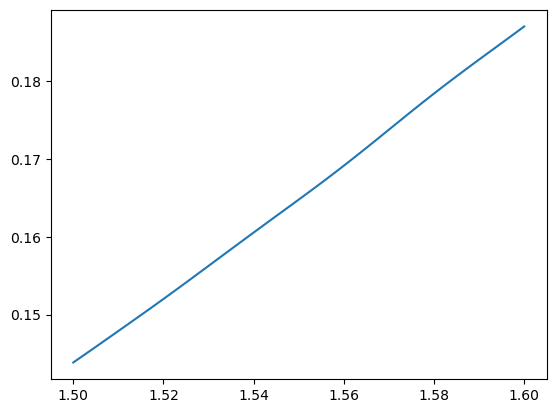

In [20]:
import gplugins
sp = np.load(s)
kappa = np.abs(sp["o3@0,o1@0"])
tau = np.abs(sp["o4@0,o1@0"])
plt.plot(wavelengths,kappa)
# plt.plot(wavelengths,tau)
# gplugins.plot.plot_sparameters(sp, logscale=True)

In [16]:
def coupler_model(
    gap: float = 0.2,
    length_x: float = 1.0,
    cross_section: gf.typings.CrossSectionSpec = "strip",
    wavelengths: list =np.linspace(1.45, 1.65, 50)
):
    component = coupler_ring_par(
        gap=gap,
        length_x=length_x,
    )
    # separation = 2.0
    # bend_factor = 4.0
    resolution = 20
    dpml = 1
    pad = 1
    s = gmeep.write_sparameters_meep_mpi(
            component,
            cores=16,
            xmargin_left=1,
            xmargin_right=1,
            ymargin_top=1,
            ymargin_bot=1,
            port_source_names=['o1'],
            port_source_modes={'o1':[0]},
            port_modes=[0],
            filepath=Path(f'/home/ramprakash/Integrated_Tests/test_outputs/coupler_ring_gap_{gap}.npz'),
            tpml=dpml,
            # extend_ports_length=0,  # Extend ports to create space for sources/monitors
            resolution=resolution,
            wavelength_start=wavelengths[0],
            wavelength_stop=wavelengths[-1],
            wavelength_points=len(wavelengths),
            port_source_offset=-0.5,
            port_monitor_offset=-0.1,
            distance_source_to_monitors=0.3,
            # port_symmetries=port_symmetries_coupler,
            layer_stack=layer_stack,
            # material_name_to_meep=dict(si=core_material),
            is_3d=False,
            overwrite=False,
            run=False
            )

    # wavelengths = s.pop("wavelengths")

    @jax.jit
    def _model(wl=1.55):
        s11 = complex_interp(wl, wavelengths, np.load(s)["o1@0,o1@0"])
        s21 = complex_interp(wl, wavelengths, np.load(s)["o2@0,o1@0"])
        s31 = complex_interp(wl, wavelengths, np.load(s)["o3@0,o1@0"])
        s41 = complex_interp(wl, wavelengths, np.load(s)["o4@0,o1@0"])
        return sax.reciprocal({
            ("o1", "o1"): s11, # reflection 
            ("o1", "o2"): s21, # isolation
            ("o1", "o3"): s31, # coupling
            ("o1", "o4"): s41, # through
        })

    return _model


coupler_model(
    gap=gap,
    length_x=length_x,
    wavelengths=wavelengths
)()

2025-12-10 02:12:57.412 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/coupler_ring_gap_0.2.npz') already exists


{('o1', 'o1'): Array(-0.03180084-8.44300366e-05j, dtype=complex128),
 ('o1', 'o2'): Array(-0.00107009+0.00051673j, dtype=complex128),
 ('o1', 'o3'): Array(-0.14948838+0.06935893j, dtype=complex128),
 ('o1', 'o4'): Array(0.8009763+0.57550373j, dtype=complex128),
 ('o2', 'o1'): Array(-0.00107009+0.00051673j, dtype=complex128),
 ('o3', 'o1'): Array(-0.14948838+0.06935893j, dtype=complex128),
 ('o4', 'o1'): Array(0.8009763+0.57550373j, dtype=complex128)}

# Building the Ring modulator circuit

**NOTE**: Here the circuit is build using the ideal coupler and also the whole is considered to be the doped region. Also there since the doped region is considered as straight no bend losses is taken to account. **So take the results with a huge grain of salt**

FIX: Add the bend losses. Propper coupler design instead of ideal coupler.

In [ ]:
# Use this to load the model without errors
def coupler_model(wl=1.55, gap=0.2, length_x=0.0):
    """
    Returns S-parameters directly (no inner function)
    """
    # Load data
    sparam_file = Path(f'test_outputs/coupler_ring_gap_{gap}.npz')
    sp_data = np.load(sparam_file, allow_pickle=True)
    wavelengths = sp_data['wavelengths']
    
    # Interpolate
    s11 = complex_interp(wl, wavelengths, sp_data["o1@0,o1@0"])
    s21 = complex_interp(wl, wavelengths, sp_data["o2@0,o1@0"])
    s31 = complex_interp(wl, wavelengths, sp_data["o3@0,o1@0"])
    s41 = complex_interp(wl, wavelengths, sp_data["o4@0,o1@0"])
    
    # Return S-parameters DIRECTLY (no @jax.jit, no inner function)
    return sax.reciprocal({
        ("o1", "o1"): s11,
        ("o1", "o2"): s21,
        ("o1", "o3"): s31,
        ("o1", "o4"): s41,
    })

# This should return S-parameters, not a function
sp = coupler_model(wl=1.55, gap=0.2)
sp

{('o1', 'o1'): Array(-0.03180084-8.44300366e-05j, dtype=complex128),
 ('o1', 'o2'): Array(-0.00107009+0.00051673j, dtype=complex128),
 ('o1', 'o3'): Array(-0.14948838+0.06935893j, dtype=complex128),
 ('o1', 'o4'): Array(0.8009763+0.57550373j, dtype=complex128),
 ('o2', 'o1'): Array(-0.00107009+0.00051673j, dtype=complex128),
 ('o3', 'o1'): Array(-0.14948838+0.06935893j, dtype=complex128),
 ('o4', 'o1'): Array(0.8009763+0.57550373j, dtype=complex128)}

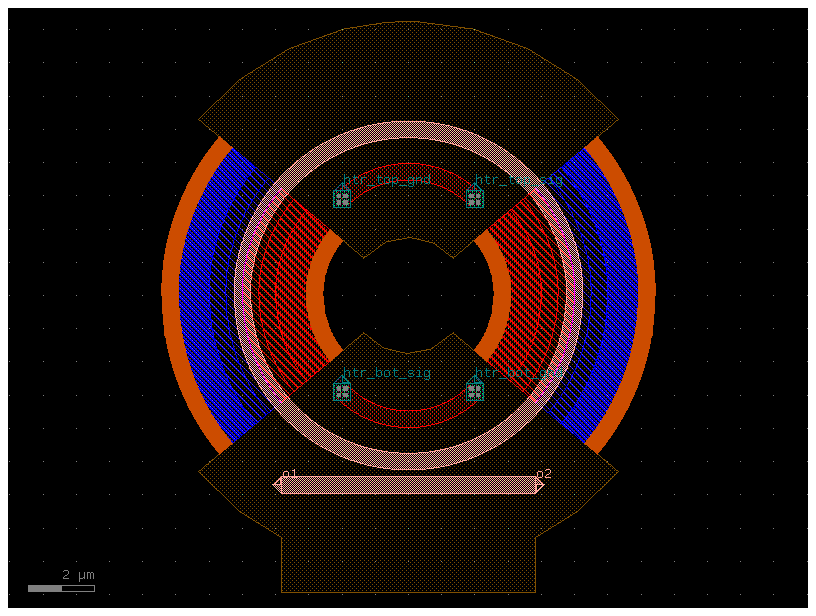

In [61]:
import gdsfactory as gf

c = gf.components.ring_double_pn(add_gap=0.2, drop_gap=0.2, radius=5, doping_angle=80, doped_heater=True, doped_heater_angle_buffer=10, doped_heater_layer='NPP', doped_heater_width=0.5, doped_heater_waveguide_offset=2.175, with_drop=False)
c.draw_ports()
c.plot()

In [110]:
# netlist={
#     "instances":{
#         "coupler_bus":"coupler",
#         "bus_wg":"straight",
#         "through_wg":"straight",
#         "passive_wg":"straight",
#         "active_wg":"active",
#     },
#     "connections":{
#         "bus_wg,o2":"coupler_bus,o1",
#         # "coupler_bus,o1":"coupler_bus,o3",
#         "coupler_bus,o3":"active_wg,o1",
#         "active_wg,o2":"coupler_bus,o2",
#         # "passive_wg,o2":"coupler_bus,o2",
#         "coupler_bus,o4":"through_wg,o1"

#         # "coupler_bus,o3":"active_wg,o1",
#         # "active_wg,o2":"passive_wg,o1",
#         # "passive_wg,o2":"coupler_bus,o2",
#         # "coupler_bus,o4":"through_wg,o1"
#     },
#     "ports":{
#         "in":"bus_wg,o1",
#         "out":"through_wg,o2",
#         # "in":"coupler_bus,o1",
#         # "out":"coupler_bus,o4",
#     },
# }
# models={
#     "active":phase_shifter_pn_junction,
#     "straight":straight_model,
#     "coupler":coupler_model
# }

# ring, info = sax.circuit(netlist=netlist, models=models)

In [109]:
# # Ring paramters 
# R = 30 # radiums
# L = 2*np.pi*R
# La = 0 # active length 
# Lp = L

# wl = jnp.linspace(1.5, 1.6, 1000)
# S = ring(wl=wl, passive_wg={"length": 0}, active_wg={"length": L, })

# plt.plot(wl * 1e3, abs(S["in", "out"]) ** 2)
# plt.ylim(-0.05, 1.05)
# plt.xlabel("λ [nm]")
# plt.ylabel("T")
# plt.show()

In [158]:
ring_length = 100.0  # [μm] Length of the ring
coupling = 0.5  # [] coupling of the coupler
wl = jnp.linspace(1.5, 1.6, 1000)  # [μm] Wavelengths to sweep over
voltage=5
_all_pass_sax, _ = sax.circuit(
    netlist={
        "instances": {
            "dc": {"component": "coupler", "settings": {"coupling": coupling}},
            "active": {
                "component": "straight",
                "settings": {
                    "length": ring_length,
                    "voltage": voltage,
                },
            },
        },
        "connections": {
            "dc,out1": "active,o1",
            "active,o2": "dc,in1",
        },
        "ports": {
            "in0": "dc,in0",
            "out0": "dc,out0",
        },
    },
    models={
        "coupler": sax.models.coupler_ideal,
        "straight": phase_shifter_pn_junction,
    },
)


def all_pass_sax(wl=1.5, voltage=50):
    sdict = sax.sdict(_all_pass_sax(wl=wl, voltage=voltage))
    return abs(sdict["in0", "out0"]) ** 2

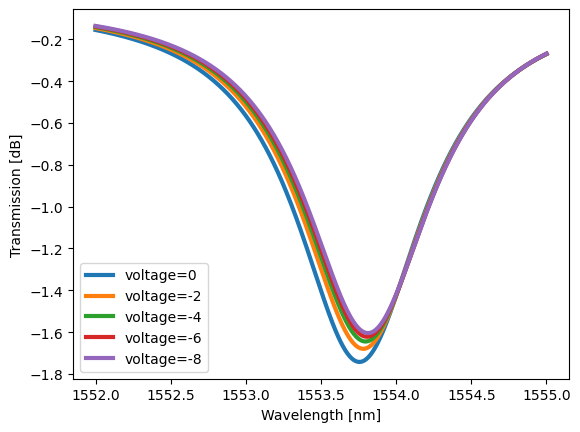

In [160]:
# fig, ax = plt.figure()
wl = jnp.linspace(1.552, 1.555, 1000)
for voltage in np.arange(0, -10, -2):
    detected_sax = all_pass_sax(wl=wl, voltage=voltage) # non-jitted evaluation time
    plt.plot(wl * 1e3, 20*np.log10(detected_sax), label=f"voltage={voltage}", lw=3)
    plt.legend()
    plt.xlabel("Wavelength [nm]")
    plt.ylabel("Transmission [dB]")
plt.show()